In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from warnings import warn

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition, inset_axes, mark_inset
from scipy.interpolate import RegularGridInterpolator, UnivariateSpline
from scipy.optimize import fmin
from tqdm.auto import tqdm

from bounded_rand_walkers.cpp import (
    bound_map,
    freehand,
    generate_data,
    get_binned_2D,
    get_binned_data,
    get_cached_filename,
    get_max_step,
)
from bounded_rand_walkers.shaper_generation import gen_rad_shaper_exact
from bounded_rand_walkers.utils import cache_dir, get_centres, match_ref, normalise

mpl.rc_file("matplotlibrc")
Path("plots").mkdir(exist_ok=True)

In [2]:
# Generate a single set of data.

pdf_kwargs = dict(width=2.0)


def get_raw_f_i(r):
    """Calculate f_i at given radii."""
    return np.array([freehand([c, 0], **pdf_kwargs) for c in r])


bound_name = "circle"
n_bins = 300  # Nr. of x, y bins.
n_raw_shaper = 10000  # Number of data points used to construct the shaper spline.
n_rad = 200  # Number of radial bins.

data_kwargs = dict(
    cache_dir=cache_dir,
    samples=int(1e7),
    seed=np.arange(10),
    blocks=2,
    bound_name=bound_name,
    pdf_name="freehand",
    **pdf_kwargs
)

#### Use the analytical f_t distribution to inform the bin sizes.

Bins will be created from 0 all the way up to the maximum expected bin size.

In [3]:
max_step = get_max_step(bound_name)

# Analytical f_i cdf spline.
cdf_f_i_radii = np.linspace(0, 2 * max_step, 1000000)
cdf_f_i_analytical = np.cumsum(get_raw_f_i(cdf_f_i_radii))
cdf_f_i_analytical /= cdf_f_i_analytical[-1]
cdf_f_i_spl = UnivariateSpline(cdf_f_i_radii, cdf_f_i_analytical, s=0, ext="const")

# 1D shaper calculation.
shaper_radii = np.linspace(0, max_step, n_raw_shaper)
raw_r_shaper = gen_rad_shaper_exact(shaper_radii, vertices=bound_name)

# Using a spline, calculate the shaper at further points.
shaper_spl = UnivariateSpline(shaper_radii, raw_r_shaper, s=0, ext="zeros")

# Generate a spline for the 'cumulative' shaper to estimate average values across bins.
cumsum_shaper = np.cumsum(raw_r_shaper)
cumsum_shaper /= cumsum_shaper[-1]
cum_shaper_spl = UnivariateSpline(shaper_radii, cumsum_shaper, s=0, ext="const")

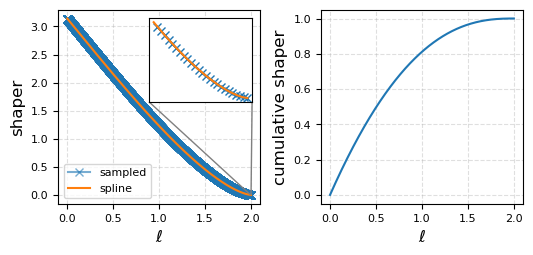

In [4]:
n_shaper_spl = 1000  # Number of points for the spline plots.

fig, axes = plt.subplots(1, 2, figsize=(6, 2.52))

ax = axes[0]

ax.plot(shaper_radii, raw_r_shaper, marker="x", label="sampled", alpha=0.6)

spl_shaper_radii = np.linspace(0, max_step, n_shaper_spl)
ax.plot(spl_shaper_radii, shaper_spl(spl_shaper_radii), label="spline")

ax.set_xlabel(r"$\ell$")
ax.set_ylabel("shaper")

ax2 = plt.axes([0, 0, 1, 1])

# Start of the inset region (and up until the maximum possible step size).
x_start = 1.995

ax2.set_xticks([])
ax2.set_yticks([])

sel = (x_start <= shaper_radii) & (shaper_radii <= max_step)
ax2.plot(shaper_radii[sel], raw_r_shaper[sel], marker="x")
sel_rad = np.linspace(x_start, max_step, 20)
ax2.plot(sel_rad, shaper_spl(sel_rad))

ip = InsetPosition(ax, [0.45, 0.525, 0.51, 0.43])
ax2.set_axes_locator(ip)
mark_inset(ax, ax2, loc1=3, loc2=4, fc="none", ec="0.5")

ax.legend(loc=3)

ax = axes[1]

ax.plot(spl_shaper_radii, cum_shaper_spl(spl_shaper_radii))
ax.set_ylabel("cumulative shaper")
ax.set_xlabel(r"$\ell$")

plt.subplots_adjust(wspace=0.3)

#### Approximate the CDF

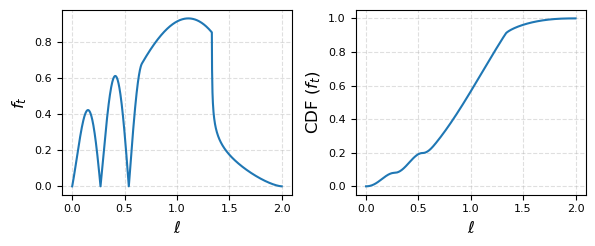

In [5]:
# Create a function to calculate the analytical transformed f_t.
def get_f_t_r_analytical(r):
    return get_raw_f_i(r) * shaper_spl(r) * r


# Take many samples in order to calculate the cdf.
cdf_r = np.linspace(0, max_step, 1000000)
cdf_t_r_analytical = np.cumsum(get_f_t_r_analytical(cdf_r))
cdf_t_r_analytical /= cdf_t_r_analytical[-1]

# Use spline interpolation to calculate the CDF at arbitrary positions based on the above.
cdf_f_t_spl = UnivariateSpline(cdf_r, cdf_t_r_analytical, s=0, ext="const")

fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))
plot_ls = np.linspace(0, max_step, 1000)
axes[0].plot(plot_ls, get_f_t_r_analytical(plot_ls))
axes[0].set_xlabel(r"$\ell$")
axes[0].set_ylabel(r"$f_t$")
axes[1].plot(plot_ls, cdf_f_t_spl(plot_ls))
axes[1].set_xlabel(r"$\ell$")
axes[1].set_ylabel(r"CDF ($f_t$)")
fig.tight_layout()

#### Generate numerics

In [6]:
filenames = get_cached_filename(squeeze=False, **data_kwargs)
if not all(p.is_file() for p in filenames):
    generate_data(
        squeeze=False, max_workers=cpu_count(), cache_only=True, **data_kwargs
    )

(
    g_x_edges,
    g_y_edges,
    g_x_centres,
    g_y_centres,
    f_t_x_edges,
    f_t_y_edges,
    f_t_x_centres,
    f_t_y_centres,
    f_t_r_edges,
    f_t_r_centres,
    g_numerical,
    f_t_numerical,
    f_t_r_numerical,
) = get_binned_data(
    filenames=filenames,
    n_bins=n_bins,
    g_bounds=(-0.5, 0.5),
    f_bounds=(-1, 1),
    f_t_r_edges=np.linspace(0, max_step, n_rad),
)

<ipython-input-6-287c1f521562>:21: JobLibCollisionWarning: Possible name collisions between functions 'get_binned_data' (/home/alexander/Documents/other/bounded-rand-walkers/src/bounded_rand_walkers/cpp/__init__.py:370) and 'get_binned_data' (/home/alexander/Documents/other/bounded-rand-walkers/src/bounded_rand_walkers/cpp/__init__.py:369)
  ) = get_binned_data(


In [7]:
# Select valid elements.
r_shaper = np.diff(cum_shaper_spl(f_t_r_edges))
valid_r = r_shaper > 0

f_i_r_num_radii = f_t_r_centres[valid_r].copy()

# Analytical calculations.

f_i_r_analytical = np.diff(cdf_f_i_spl(f_t_r_edges))

# 1D analytical transformed distribution.
f_t_r_analytical = f_i_r_analytical * r_shaper

# Analytical transformed.
f_i_r_analytical_trans = f_t_r_analytical[valid_r] / r_shaper[valid_r]

f_t_norm = normalise(f_t_r_edges, f_t_r_analytical * f_t_r_centres)

# Numerics calculations.

# 1D reconstruction of the intrinsic pdf as a function of step length only.
f_i_r_num = f_t_r_numerical[valid_r] / r_shaper[valid_r]

In [8]:
# Analytical normed f_t.
# Reference for all f_t plots.
f_t_r_analytical_norm = normalise(f_t_r_edges, f_t_r_analytical * f_t_r_centres)

f_t_num_factor = match_ref(
    x=f_t_r_centres,
    y=f_t_r_numerical,
    ref_x=f_t_r_centres,
    ref_y=f_t_r_analytical_norm,
    return_factor=True,
)

In [9]:
# Analytical transformed, normed f_i.
# This is the reference for all f_i plots (albeit over a restricted interval).
f_i_r_analytical_trans_norm = normalise(
    f_i_r_num_radii, f_i_r_analytical_trans * f_i_r_num_radii
)
f_i_ref_radii_sel = f_i_r_num_radii < fmin(
    lambda x: (cdf_f_t_spl(x[0]) - 0.8) ** 2, [0.7 * max_step], disp=False
)
f_i_ref_radii = f_i_r_num_radii[f_i_ref_radii_sel]
f_i_ref = f_i_r_analytical_trans_norm[f_i_ref_radii_sel]

# Higher samples numerical scaling factor.
f_i_num_factor = match_ref(
    x=f_i_r_num_radii,
    y=f_i_r_num,
    ref_x=f_i_ref_radii,
    ref_y=f_i_ref,
    return_factor=True,
)

# Analytical scaling factor.
f_i_analytical_factor = match_ref(
    x=f_t_r_centres,
    y=f_i_r_analytical * f_t_r_centres,
    ref_x=f_i_ref_radii,
    ref_y=f_i_ref,
    return_factor=True,
)

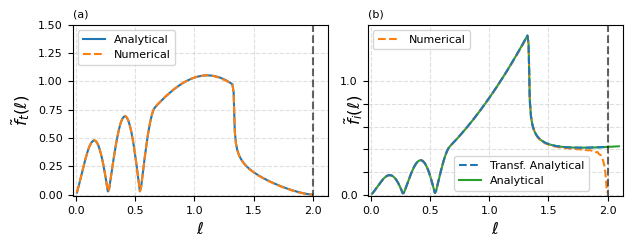

In [10]:
bin_width = np.mean(np.diff(f_t_r_edges))
analytical_f_i_edges = np.arange(0, 1.05 * max_step + bin_width, bin_width)
analytical_f_i_centres = get_centres(analytical_f_i_edges)

analytical_f_i_args = (
    analytical_f_i_centres,
    f_i_analytical_factor
    * np.diff(cdf_f_i_spl(analytical_f_i_edges))
    * analytical_f_i_centres,
)

analytical_f_i_kwargs = dict(
    label=r"Analyt. $\tilde{f}_i(\ell)$",
    zorder=1,
    linestyle="-",
    c="C2",
)

# Plot f_t and f_i.
fig, axes = plt.subplots(1, 2, figsize=(6.3, 2.52))

# Plot f_t.
ax = axes[0]

ax.plot(
    f_t_r_centres,
    f_t_r_analytical_norm,
    label="Analytical",
    zorder=1,
)
ax.plot(
    f_t_r_centres,
    f_t_num_factor * f_t_r_numerical,
    label="Numerical",
    zorder=2,
    linestyle="--",
    c="C1",
)

# Plot f_i.
ax = axes[1]

(t1,) = ax.plot(
    f_i_r_num_radii,
    f_i_r_analytical_trans_norm,
    # label="Transformed Analytical",
    zorder=2,
    linestyle="--",
    c="C0",
)

(t2,) = ax.plot(
    *analytical_f_i_args,
    **analytical_f_i_kwargs,
)


(b1,) = ax.plot(
    f_i_r_num_radii,
    f_i_num_factor * f_i_r_num,
    # label="Numerical",
    zorder=1,
    c="C1",
    linestyle="--",
)

# Fix y-axis limits so they do not blow up due to the variability of the below.
ylim = ax.get_ylim()
ax.set_ylim(*ylim)
ax.autoscale(False)

# Labels.
axes[0].set_xlabel(r"$\ell$")
axes[0].set_ylabel(r"$\tilde{f}_t(\ell)$")

axes[1].set_xlabel(r"$\ell$")
axes[1].set_ylabel(r"$\tilde{f}_i(\ell)$", labelpad=-18)

# Grids and titles.
for ax, title in zip(axes, ["(a)", "(b)"]):
    ax.text(0, 1.04, title, transform=ax.transAxes)

ylim = (-0.01, 1.5)

# Add vertical lines to show the maximum step size.
max_step_kwargs = dict(
    linestyle="--",
    alpha=0.6,
    color="k",
    # Uncomment to show legend item for this line.
    # label=r"Max. $\ell\ (\sqrt{2})$",
)
for ax in axes:
    ax.vlines(max_step, -1, 3, **max_step_kwargs)

x_extent = np.max(analytical_f_i_edges)
margin = x_extent * 0.015
for ax in axes:
    ax.set_ylim(*ylim)
    ax.set_xlim(-margin, x_extent + margin)

axes[1].set_yticks(np.arange(0, 1.2, 0.2))
axes[1].set_yticklabels(["0.0", "", "", "", "", "1.0"])

# Legends.
axes[0].legend(loc="upper left")

l1 = axes[1].legend([t1, t2], ["Transf. Analytical", "Analytical"], loc=(0.34, 0.03))
l2 = axes[1].legend([b1], ["Numerical"], loc="upper left")
axes[1].add_artist(l1)

# Move the two subplots closer to each other.
fig.tight_layout()

# Finally, save into the 'plots' directory.
fig.savefig((Path("plots") / f"{bound_name}_reconstruction").with_suffix(".png"))